# Earthquake Prediction

In [302]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cb
from sklearn import preprocessing, model_selection, linear_model
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix, recall_score

In [303]:
filepath = './data/earthquakes.csv'

In [304]:
df = pd.read_csv(filepath)
df = df.set_index('time')
df.index = pd.to_datetime(df.index)
df = df[::-1]
df = df.ffill(axis=0)
df.head()

,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,net,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
time,,,,,,,,,,,,,,,,,,,,,
2020-07-12 10:31:53.318000+00:00,67.791600,-158.636400,15.00,1.10,ml,NaN,NaN,NaN,0.42,ak,...,2020-08-04T02:49:26.410Z,"85 km NNW of Ambler, Alaska",earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak
2020-07-12 10:38:04.580000+00:00,33.177833,-116.127833,11.36,0.72,ml,35.0,60.0,0.040210,0.19,ci,...,2020-07-13T22:21:26.937Z,"4km N of Ocotillo Wells, CA",earthquake,0.24,0.34,0.158,12.0,reviewed,ci,ci
2020-07-12 10:38:50.280000+00:00,38.816334,-122.813500,3.17,0.91,md,22.0,46.0,0.007542,0.02,nc,...,2020-07-12T11:51:04.930Z,"7km NW of The Geysers, CA",earthquake,0.26,0.50,0.130,3.0,automatic,nc,nc
2020-07-12 10:40:29.962000+00:00,63.047100,-150.433700,107.20,1.10,ml,22.0,46.0,0.007542,0.21,ak,...,2020-08-04T02:49:33.285Z,"63 km NNE of Petersville, Alaska",earthquake,0.26,0.50,0.130,3.0,reviewed,ak,ak
2020-07-12 10:50:55.660000+00:00,36.073167,-117.642167,4.75,0.88,ml,13.0,85.0,0.110600,0.14,ci,...,2020-07-12T16:37:38.032Z,"28km E of Coso Junction, CA",earthquake,0.27,2.64,0.189,9.0,reviewed,ci,ci


In [305]:
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,35245.000000,35245.000000,35245.000000,35245.000000,35244.000000,35244.000000,35244.000000,35245.000000,35244.000000,35245.000000,35244.000000,35244.000000
mean,37.167296,-108.587333,21.477970,1.662998,22.923874,116.367907,0.802746,0.275335,1.841804,4.240555,0.256224,16.690160
std,19.093452,67.751199,54.360028,1.311455,20.870127,60.163061,2.755236,0.272876,3.228899,389.379273,0.471036,32.924174
min,-65.352200,-179.996400,-3.730000,-1.430000,0.000000,11.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000
25%,33.420500,-149.703200,3.600000,0.800000,10.000000,71.000000,0.025000,0.100000,0.270000,0.470000,0.105000,5.000000
50%,38.151200,-118.777667,8.000000,1.340000,17.000000,102.000000,0.059910,0.160000,0.470000,0.800000,0.161000,9.000000
75%,47.511900,-113.778167,14.560000,2.110000,28.000000,150.000000,0.165500,0.400000,1.020000,1.780000,0.236515,18.000000
max,87.349200,180.000000,647.998000,7.800000,444.000000,355.000000,43.236000,2.460000,26.400000,73091.100000,5.520000,760.000000


In [306]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35245 entries, 2020-07-12 10:31:53.318000+00:00 to 2022-10-06 13:10:10.910000+00:00
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   latitude         35245 non-null  float64
 1   longitude        35245 non-null  float64
 2   depth            35245 non-null  float64
 3   mag              35245 non-null  float64
 4   magType          35245 non-null  object 
 5   nst              35244 non-null  float64
 6   gap              35244 non-null  float64
 7   dmin             35244 non-null  float64
 8   rms              35245 non-null  float64
 9   net              35245 non-null  object 
 10  id               35245 non-null  object 
 11  updated          35245 non-null  object 
 12  place            35245 non-null  object 
 13  type             35245 non-null  object 
 14  horizontalError  35244 non-null  float64
 15  depthError       35245 non-null  float64
 1

In [307]:
df.isnull().sum()

latitude           0
longitude          0
depth              0
mag                0
magType            0
nst                1
gap                1
dmin               1
rms                0
net                0
id                 0
updated            0
place              0
type               0
horizontalError    1
depthError         0
magError           1
magNst             1
status             0
locationSource     0
magSource          0
dtype: int64

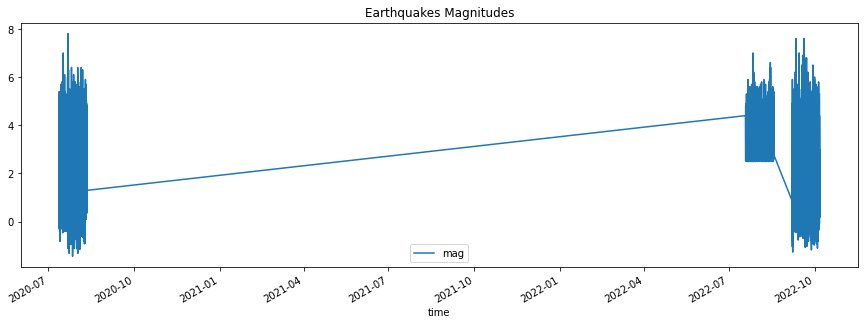

In [308]:
df.plot(figsize=(15, 5), title='Earthquakes Magnitudes', y='mag')
plt.show()

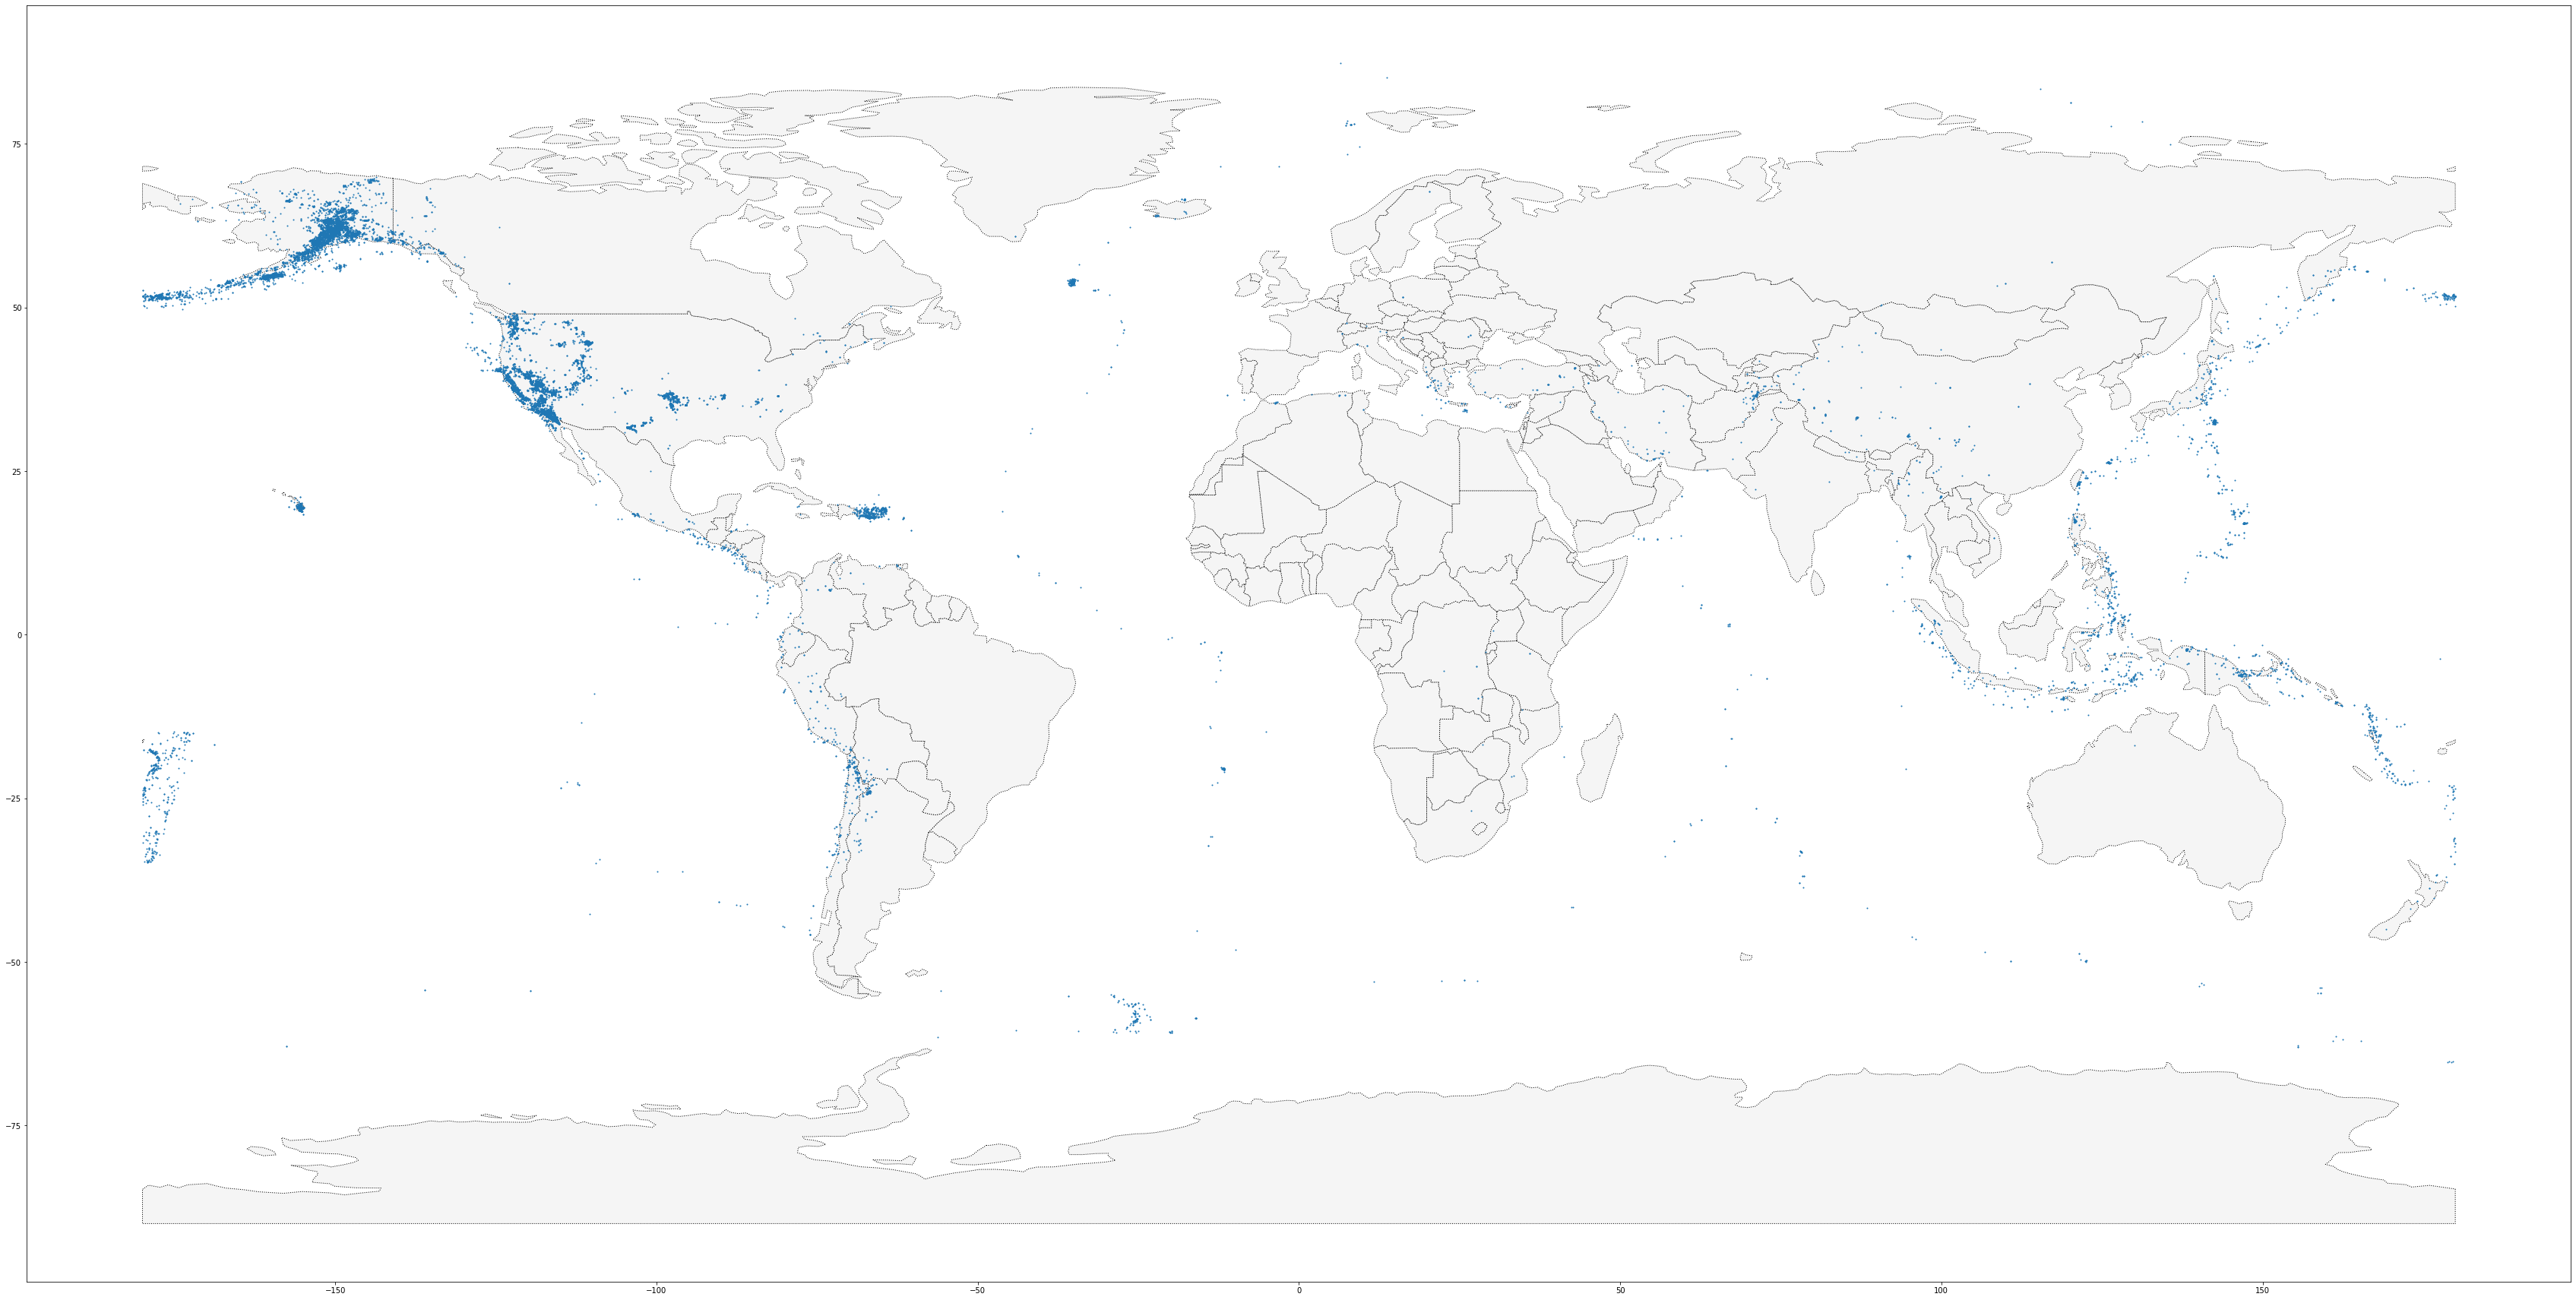

In [309]:
earthquakes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
earthquakes.crs = 'EPSG:4326'

world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)

ax = world.plot(figsize=(60, 60), color='whitesmoke', linestyle=':', edgecolor='black')
earthquakes.to_crs(epsg=4326).plot(markersize=1, ax=ax)
plt.show()

In [310]:
print(f'Min magnitude: {df.mag.min()}')
print(f'Max magnitude: {df.mag.max()}')

Min magnitude: -1.43
Max magnitude: 7.8


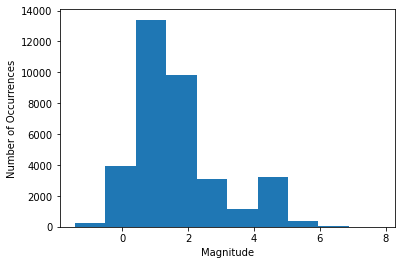

In [311]:
plt.hist(df.mag)
plt.xlabel('Magnitude')
plt.ylabel('Number of Occurrences')
plt.show()

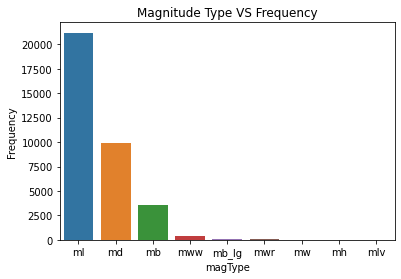

local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)


In [312]:
sns.countplot(data=df, x='magType')
plt.ylabel('Frequency')
plt.title('Magnitude Type VS Frequency')
plt.show()

print('local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)')

In [313]:
df.loc[df.mag >= 8, 'Class'] = 'Disastrous'
df.loc[(df.mag >= 7) & (df.mag < 7.9), 'Class'] = 'Major'
df.loc[(df.mag >= 6) & (df.mag < 6.9), 'Class'] = 'Strong'
df.loc[(df.mag >= 5.5) & (df.mag < 5.9), 'Class'] = 'Moderate'

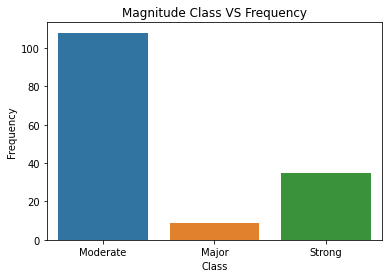

In [314]:
sns.countplot(data=df, x='Class')
plt.ylabel('Frequency')
plt.title('Magnitude Class VS Frequency')
plt.show()

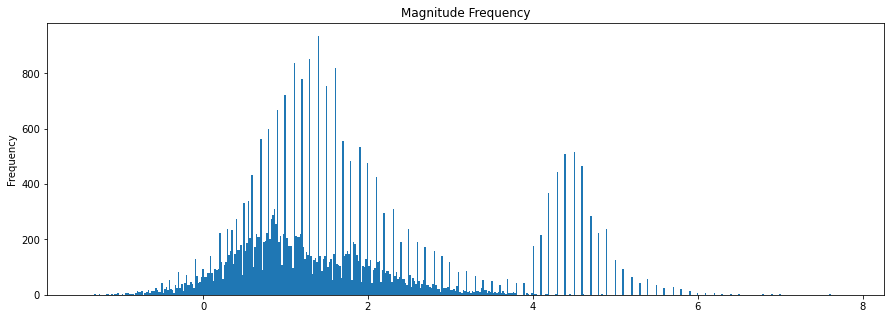

In [315]:
df.mag.plot(kind='hist', bins=500, figsize=(15, 5))
plt.title('Magnitude Frequency')
plt.show()

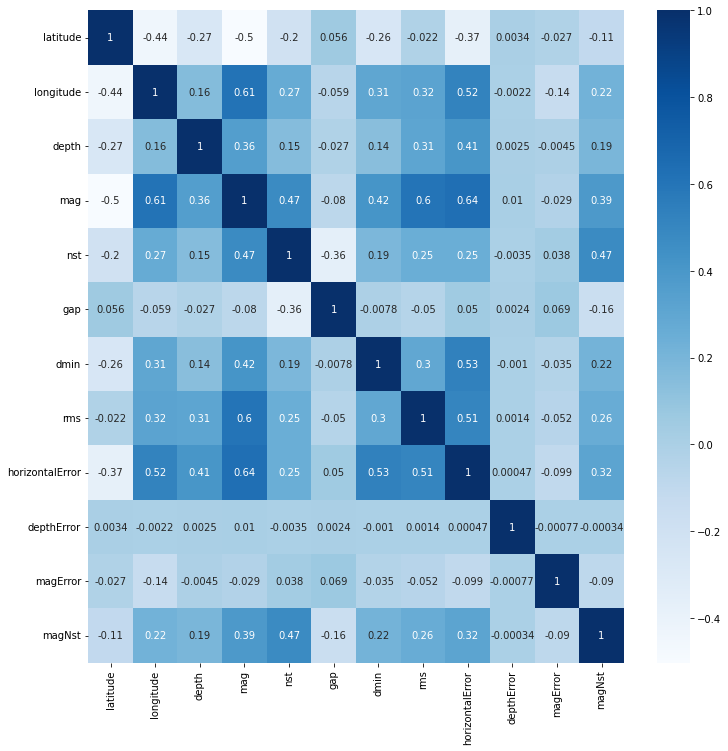

In [316]:
corr_matrix = df.corr() 
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.show()

In [317]:
threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
df = df.drop(to_drop, axis=1)

In [318]:
for column in df.columns:
    if df[column].isna().mean() > 0.3:
        df = df.drop(column, axis=1) 

In [319]:
df.place = df.place.str.split(', ', expand=True)[1]
df.place.head() 

time
2020-07-12 10:31:53.318000+00:00    Alaska
2020-07-12 10:38:04.580000+00:00        CA
2020-07-12 10:38:50.280000+00:00        CA
2020-07-12 10:40:29.962000+00:00    Alaska
2020-07-12 10:50:55.660000+00:00        CA
Name: place, dtype: object

In [320]:
print(f'Total locations: {len(set(df.place))}')

Total locations: 135


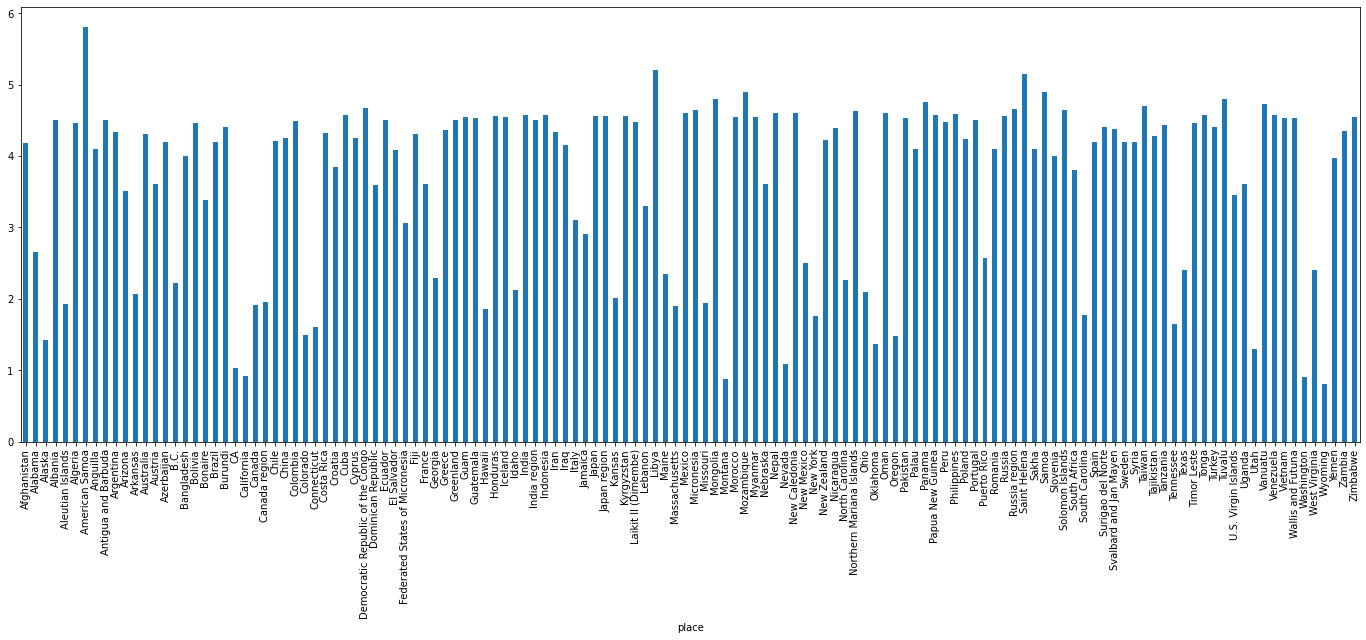

In [321]:
df.groupby(['place'])['mag'].mean().plot(kind='bar',figsize=(24, 8))
plt.show()

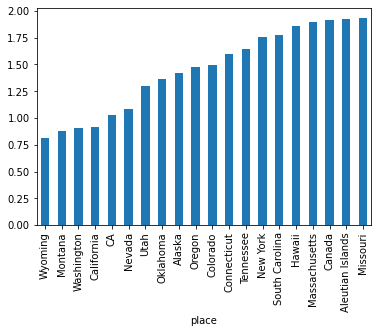

In [322]:
df.groupby(['place'])['mag'].mean().nsmallest(20).plot(kind='bar')
plt.show()

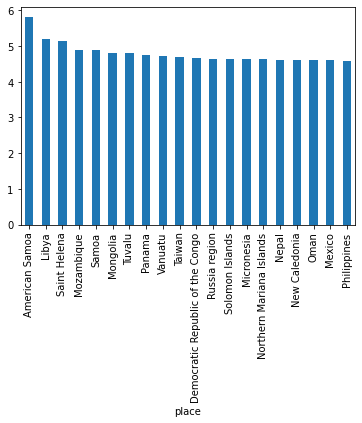

In [323]:
df.groupby(['place'])['mag'].mean().nlargest(20).plot(kind='bar')
plt.show()

In [324]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    """Creates time series features based on time series index."""
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['quarter'] = df.index.quarter
    df['season'] = df.month % 12 // 3 + 1
    return df

def add_lags(df: pd.DataFrame) -> pd.DataFrame:
    df['mag_5d_lag'] = df.mag.shift(5)
    df['mag_10d_lag'] = df.mag.shift(10)
    df['mag_15d_lag'] = df.mag.shift(15)

    df['depth_5d_lag'] = df.depth.shift(5)
    df['depth_10d_lag'] = df.depth.shift(10)
    df['depth_15d_lag'] = df.depth.shift(15)
    return df

def add_rolling_windows(df: pd.DataFrame) -> pd.DataFrame:
    df['mag_5d_avg'] = df.mag.rolling(window=5,center=False).mean() 
    df['mag_10d_avg'] = df.mag.rolling(window=10,center=False).mean() 
    df['mag_15d_avg'] = df.mag.rolling(window=15,center=False).mean()
    df['mag_5d_min'] = df.mag.rolling(window=5,center=False).min() 
    df['mag_10d_min'] = df.mag.rolling(window=10,center=False).min() 
    df['mag_15d_min'] = df.mag.rolling(window=15,center=False).min() 
    df['mag_5d_max'] = df.mag.rolling(window=5,center=False).max() 
    df['mag_10d_max'] = df.mag.rolling(window=10,center=False).max() 
    df['mag_15d_max'] = df.mag.rolling(window=15,center=False).max() 
    df['mag_5d_std'] = df.mag.rolling(window=5,center=False).std() 
    df['mag_10d_std'] = df.mag.rolling(window=10,center=False).std() 
    df['mag_15d_std'] = df.mag.rolling(window=15,center=False).std() 

    df['depth_5d_avg'] = df.depth.rolling(window=5,center=False).mean() 
    df['depth_10d_avg'] = df.depth.rolling(window=10,center=False).mean() 
    df['depth_15d_avg'] = df.depth.rolling(window=15,center=False).mean()
    df['depth_5d_min'] = df.depth.rolling(window=5,center=False).min() 
    df['depth_10d_min'] = df.depth.rolling(window=10,center=False).min() 
    df['depth_15d_min'] = df.depth.rolling(window=15,center=False).min() 
    df['depth_5d_max'] = df.depth.rolling(window=5,center=False).max() 
    df['depth_10d_max'] = df.depth.rolling(window=10,center=False).max() 
    df['depth_15d_max'] = df.depth.rolling(window=15,center=False).max()  
    df['depth_5d_std'] = df.depth.rolling(window=5,center=False).std() 
    df['depth_10d_std'] = df.depth.rolling(window=10,center=False).std() 
    df['depth_15d_std'] = df.depth.rolling(window=15,center=False).std() 
    return df

data = []
for place in df.place.unique():
    temp = df.loc[df.place == place]
    temp = create_features(temp)
    temp = add_lags(temp)
    temp = add_rolling_windows(temp)

    data.append(temp)

df = pd.concat(data)

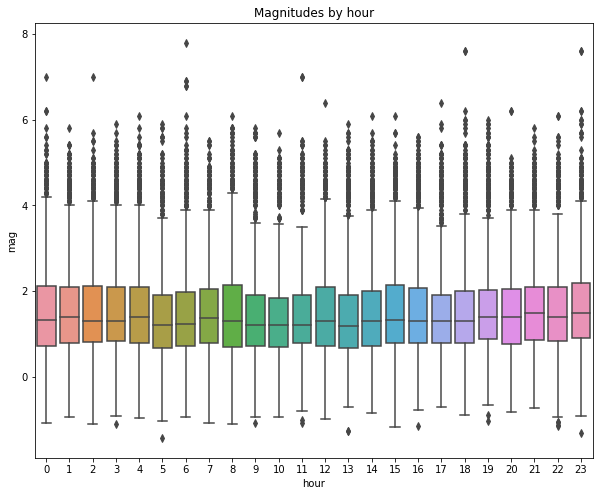

In [325]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='mag')
ax.set_title('Magnitudes by hour')
plt.show()

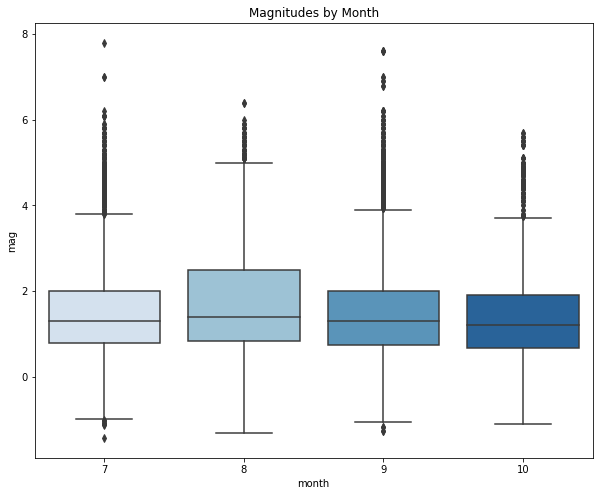

In [326]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='mag', palette='Blues')
ax.set_title('Magnitudes by Month')
plt.show()

In [345]:
features = [
    'dayofyear', 
    'hour', 
    # 'dayofweek', 
    # 'month', 
    # 'season',
    # 'year', 
    'mag_5d_lag', 
    # 'mag_10d_lag', 
    # 'mag_15d_lag', 
    'mag_5d_avg',
    # 'mag_10d_avg', 
    # 'mag_15d_avg',
    'mag_5d_min',
    # 'mag_10d_min',
    # 'mag_15d_min',
    'mag_5d_max',
    # 'mag_10d_max',
    # 'mag_15d_max',
    'mag_5d_std',
    # 'mag_10d_std',
    # 'mag_15d_std',
    # 'depth_5d_lag',
    # 'depth_10d_lag',
    # 'depth_15d_lag',
    # 'depth_5d_avg',
    # 'depth_10d_avg',
    # 'depth_15d_avg',
    # 'depth_5d_min',
    # 'depth_10d_min',
    # 'depth_15d_min',
    # 'depth_5d_max',
    # 'depth_10d_max',
    # 'depth_15d_max',
    # 'depth_5d_std',
    # 'depth_10d_std',
    # 'depth_15d_std',
    'latitude', 
    'longitude',
]
cat_features = ['place']
target = 'mag'

In [346]:
date = '2022-09-25 00:00:00.000000+00:00'

df_train = df.loc[df.index < date]
df_train = df_train[features + cat_features + [target]]

df_test = df.loc[df.index >= date]
df_test = df_test[features + cat_features + [target]]

In [347]:
print(f'Test size: {len(df_test) / (len(df_test) + len(df_train))}')

Test size: 0.20883582813162838


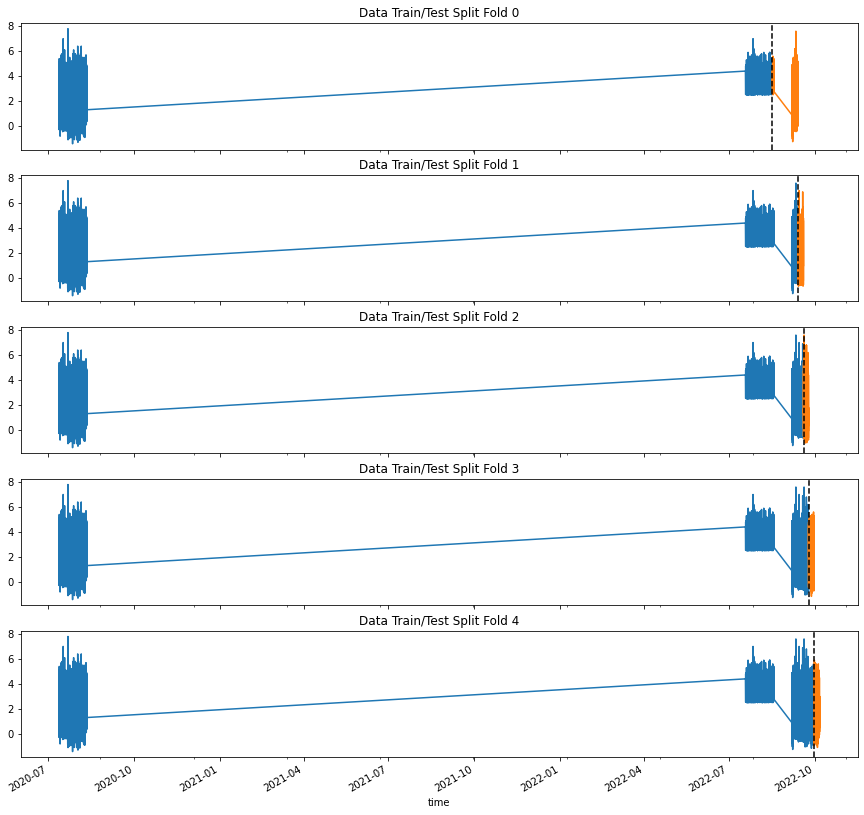

In [348]:
tss = model_selection.TimeSeriesSplit(n_splits=5, test_size=3600, gap=24)
df = df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train.mag.plot(ax=axs[fold], label='Training Set', title=f'Data Train/Test Split Fold {fold}')
    test.mag.plot(ax=axs[fold], label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1

plt.show()

In [349]:
fold = 0
predictions = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    x_train = train[features + cat_features]
    y_train = train[target]

    x_test = test[features + cat_features]
    y_test = test[target]

    model = cb.CatBoostRegressor(
        depth=7, 
        learning_rate=0.01, 
        iterations=1000, 
        early_stopping_rounds=50,
        cat_features=cat_features,
    )
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)], verbose=100)

    y_pred = model.predict(x_test)
    predictions.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

0:	learn: 1.2202414	test: 1.2202414	test1: 1.2959242	best: 1.2959242 (0)	total: 27.1ms	remaining: 27s
100:	learn: 0.7240364	test: 0.7240364	test1: 0.7669539	best: 0.7669539 (100)	total: 896ms	remaining: 7.98s
200:	learn: 0.5964427	test: 0.5964427	test1: 0.6469335	best: 0.6469335 (200)	total: 1.76s	remaining: 6.99s
300:	learn: 0.5568770	test: 0.5568770	test1: 0.6212067	best: 0.6212067 (300)	total: 2.62s	remaining: 6.09s
400:	learn: 0.5351240	test: 0.5350456	test1: 0.6086771	best: 0.6086658 (398)	total: 3.27s	remaining: 4.88s
500:	learn: 0.5205922	test: 0.5203945	test1: 0.6015332	best: 0.6014354 (498)	total: 3.95s	remaining: 3.94s
600:	learn: 0.5095875	test: 0.5093576	test1: 0.5964839	best: 0.5964798 (598)	total: 4.6s	remaining: 3.06s
700:	learn: 0.5000218	test: 0.4998066	test1: 0.5914139	best: 0.5914139 (700)	total: 5.27s	remaining: 2.25s
800:	learn: 0.4923729	test: 0.4921809	test1: 0.5883325	best: 0.5883325 (800)	total: 6.02s	remaining: 1.49s
900:	learn: 0.4857941	test: 0.4856245	test1

In [350]:
print(f'Score across folds {np.mean(scores)}')
print(f'Fold scores:{scores}')

Score across folds 0.529643267242051
Fold scores:[0.5843289088089436, 0.5365658927205567, 0.5043198759059984, 0.4925398039678352, 0.530461854806921]


In [351]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    df_train[features + cat_features],
    df_train[target], 
    test_size=0.2, 
    random_state=42,
)

In [352]:
grid = {
    'depth': [5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [1500],
}

model = cb.CatBoostRegressor(early_stopping_rounds=50, cat_features=cat_features)
grid_search_result = model.grid_search(grid, x_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.0132338	test: 2.0159374	best: 2.0159374 (0)	total: 12.8ms	remaining: 12.7s
1:	learn: 1.9954545	test: 1.9982883	best: 1.9982883 (1)	total: 21.3ms	remaining: 10.6s
2:	learn: 1.9779495	test: 1.9808410	best: 1.9808410 (2)	total: 27.3ms	remaining: 9.06s
3:	learn: 1.9608839	test: 1.9636228	best: 1.9636228 (3)	total: 35.3ms	remaining: 8.8s
4:	learn: 1.9441111	test: 1.9469898	best: 1.9469898 (4)	total: 40.1ms	remaining: 7.98s
5:	learn: 1.9272692	test: 1.9301838	best: 1.9301838 (5)	total: 43.5ms	remaining: 7.21s
6:	learn: 1.9106434	test: 1.9134353	best: 1.9134353 (6)	total: 50ms	remaining: 7.09s
7:	learn: 1.8941785	test: 1.8969807	best: 1.8969807 (7)	total: 55ms	remaining: 6.82s
8:	learn: 1.8779123	test: 1.8806111	best: 1.8806111 (8)	total: 59.9ms	remaining: 6.59s
9:	learn: 1.8615344	test: 1.8642652	best: 1.8642652 (9)	total: 66.2ms	remaining: 6.55s
10:	learn: 1.8456231	test: 1.8485452	best: 1.8485452 (10)	total: 70.3ms	remaining: 6.32s
11:	learn: 1.8299404	test: 1.8328080	best: 1.8

In [353]:
grid_search_result['params']

{'depth': 5, 'iterations': 1000, 'learning_rate': 0.1}

In [354]:
prediction = model.predict(x_test)
print(f'Accuracy of Model: {model.score(x_test, y_test)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, prediction))}')

Accuracy of Model: 0.8712187685882702
Mean Absolute Error: 0.3333669582262818
Root Mean Squared Error: 0.4503622615005744


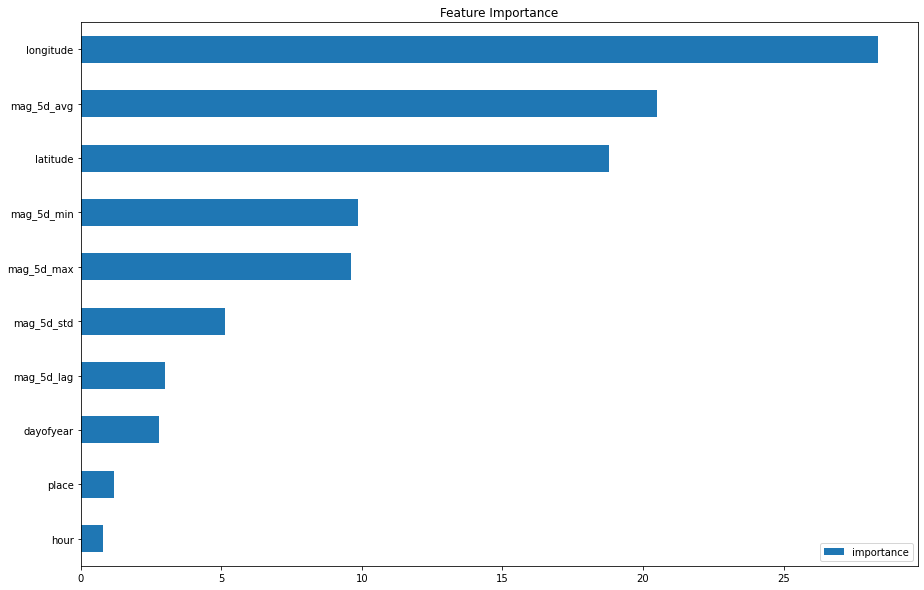

In [355]:
fi = pd.DataFrame(data=model.feature_importances_, index=model.feature_names_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', figsize=(15, 10))
plt.show()

Accuracy of Model: 0.8419495673953822
Mean Absolute Error: 0.34245234582136624
Root Mean Squared Error: 0.4720352158775835


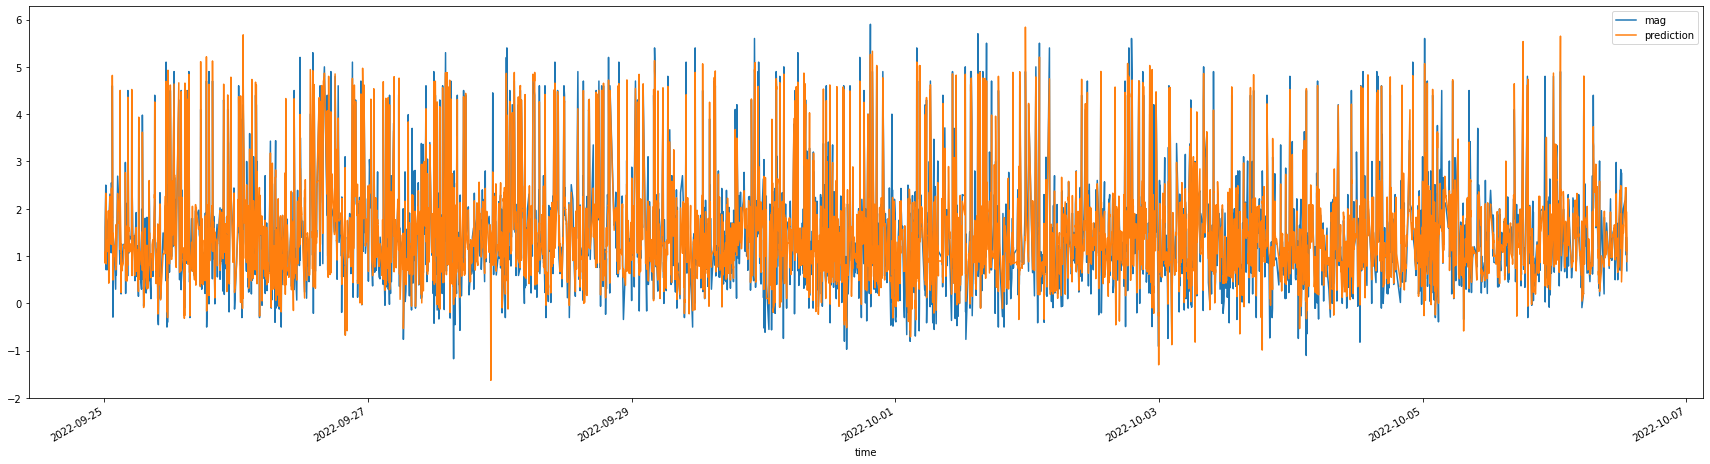

In [356]:
prediction = model.predict(df_test[features + cat_features])
print(f'Accuracy of Model: {model.score(df_test[features + cat_features], df_test[target])}')
print(f'Mean Absolute Error: {mean_absolute_error(df_test[target], prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(df_test[target], prediction))}')

df_plot = pd.DataFrame({'mag': df_test[target], 'prediction': prediction}, index=df_test.index)
df_plot = df_plot[::-1]
df_plot.plot(figsize=(30, 8))
plt.show()

In [357]:
live_data = pd.read_csv('https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&eventtype=earthquake')
live_data = live_data.set_index('time')
live_data.index = pd.to_datetime(live_data.index)
live_data = live_data[::-1]
live_data = live_data.ffill()

In [358]:
data = []
for place in live_data.place.unique():
    temp = live_data.loc[live_data.place == place]
    temp = create_features(temp)
    temp = add_lags(temp)
    temp = add_rolling_windows(temp)

    data.append(temp)

live_data = pd.concat(data)

Accuracy of Model: 0.653814800319316
Mean Absolute Error: 0.5995729461105893
Root Mean Squared Error: 0.7713880192361133


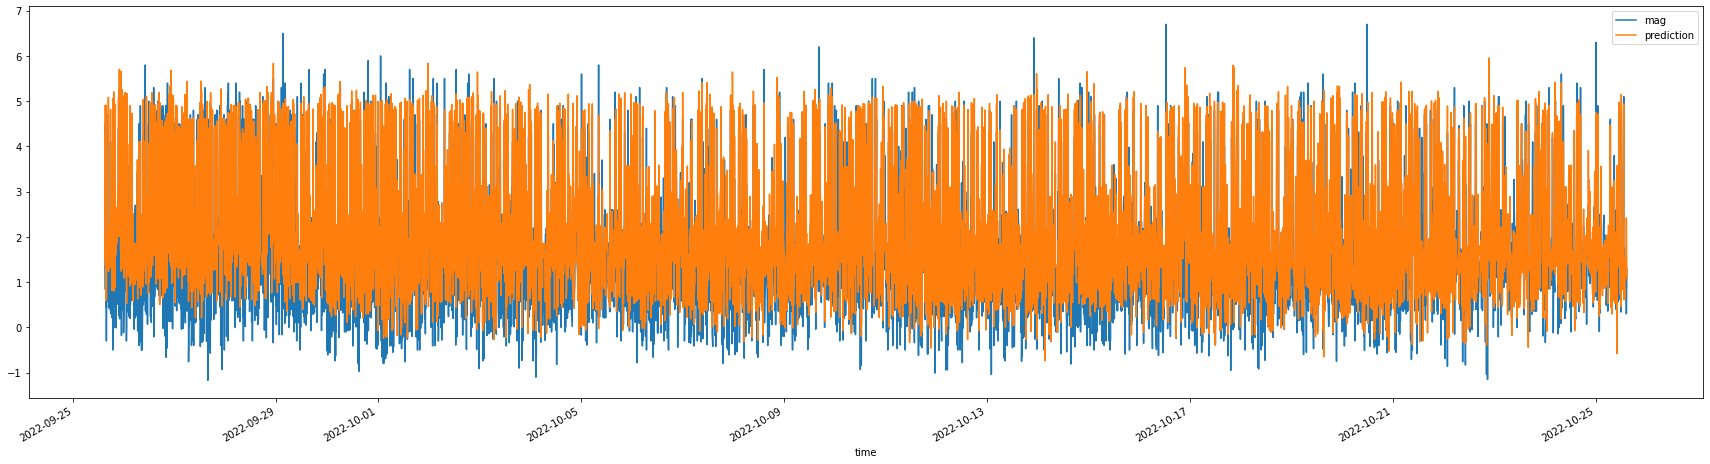

In [359]:
live_prediction = model.predict(live_data[features + cat_features])
print(f'Accuracy of Model: {model.score(live_data[features + cat_features], live_data[target])}')
print(f'Mean Absolute Error: {mean_absolute_error(live_data[target], live_prediction)}')
print(f'Root Mean Squared Error: {np.sqrt(mean_squared_error(live_data[target], live_prediction))}')

df_live = pd.DataFrame({'mag': live_data[target], 'prediction': live_prediction}, index=live_data.index)
df_live = df_live[::-1]
df_live.plot(figsize=(30, 8))
plt.show()

In [361]:
# model.save_model('../app/server/app/ml/model')